# Traffic Light Classifier
---

In this project, we'll use computer vision techniques to build a classifier for images of traffic lights! In folder [traffic_light_images](traffic_light_images/) there is a dataset of traffic light images in which one of three lights is illuminated: red, yellow, or green.

In this notebook, we'll pre-process these images, extract features that will help us distinguish the different types of images, and use those features to classify the traffic light images into three classes: red, yellow, or green. The tasks will be broken down into a few sections:

1. **Loading and visualizing the data**. 
      The first step in any classification task is to be familiar with your data; we'll load in the images of traffic lights and visualize them!

2. **Pre-processing**. 
    The input images and output labels need to be standardized. This way, we can analyze all the input images using the same classification pipeline, and we know what output to expect when we eventually classify a *new* image.
    
3. **Feature extraction**. 
    Next, we'll extract some features from each image that will help distinguish and eventually classify these images.
   
4. **Classification and visualizing error**. 
    Finally, we'll write one function that uses our features to classify *any* traffic light image. This function will take in an image and output a label. We'll also determine the accuracy of our classification model.    
    
5. **Evaluate the model**.
    Our classifier must be >90% accurate and never classify any red lights as green.
    
Here are some sample images from the dataset (from left to right: red, green, and yellow traffic lights):

<img src="media/all_lights.png" width="50%" height="50%">

# 1. Loading and Visualizing the Traffic Light Dataset

This traffic light dataset consists of 1484 number of color images in 3 categories - red, yellow, and green. As with most human-sourced data, the data is not evenly distributed among the types. There are:
* 904 red traffic light images
* 536 green traffic light images
* 44 yellow traffic light images

*Note: All images come from this [MIT self-driving car course](https://selfdrivingcars.mit.edu/) and are licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](https://creativecommons.org/licenses/by-sa/4.0/).*

### Import resources

Import the libraries and resources that we'll need.

In [1]:
import cv2 # computer vision library
import helpers # helper functions

import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # for loading in images

%matplotlib inline

## Training and Testing Data

All 1484 of the traffic light images are separated into training and testing datasets. 

* 80% of these images are training images, to a classifier.
* 20% are test images, which will be used to test the accuracy of the classifier.
* All images are pictures of 3-light traffic lights with one light illuminated.

## Define the image directories

First, we set some variables to keep track of some where our images are stored:

    IMAGE_DIR_TRAINING: the directory where our training image data is stored
    IMAGE_DIR_TEST: the directory where our test image data is stored

In [2]:
# Image data directories
IMAGE_DIR_TRAINING = "traffic_light_images/training/"
IMAGE_DIR_TEST = "traffic_light_images/test/"

## Load the datasets

These first few lines of code will load the training traffic light images and store all of them in a variable, `IMAGE_LIST`. This list contains the images and their associated label ("red", "yellow", "green"). 

The `load_dataset` function takes in the name of an image directory and returns a list of images and their associated labels. You can read more at [glob library](https://pymotw.com/2/glob/).

For example, the first image-label pair in `IMAGE_LIST` can be accessed by index: 
``` IMAGE_LIST[0][:]```.


In [3]:
# Using the load_dataset function in helpers.py
# Load training data
IMAGE_LIST = helpers.load_dataset(IMAGE_DIR_TRAINING)


## Visualize the Data

The first steps in analyzing any dataset are to 1. load the data and 2. look at the data. Seeing what it looks like will give an idea of what to look for in the images, what kind of noise or inconsistencies we have to deal with, and so on. This will help us understand the image dataset, and **understanding a dataset is part of making predictions about the data**.

---
### Visualize the input images

Visualize and explore the image data! Code to display an image in `IMAGE_LIST`:
* Display the image
* Print out the shape of the image 
* Print out its corresponding label

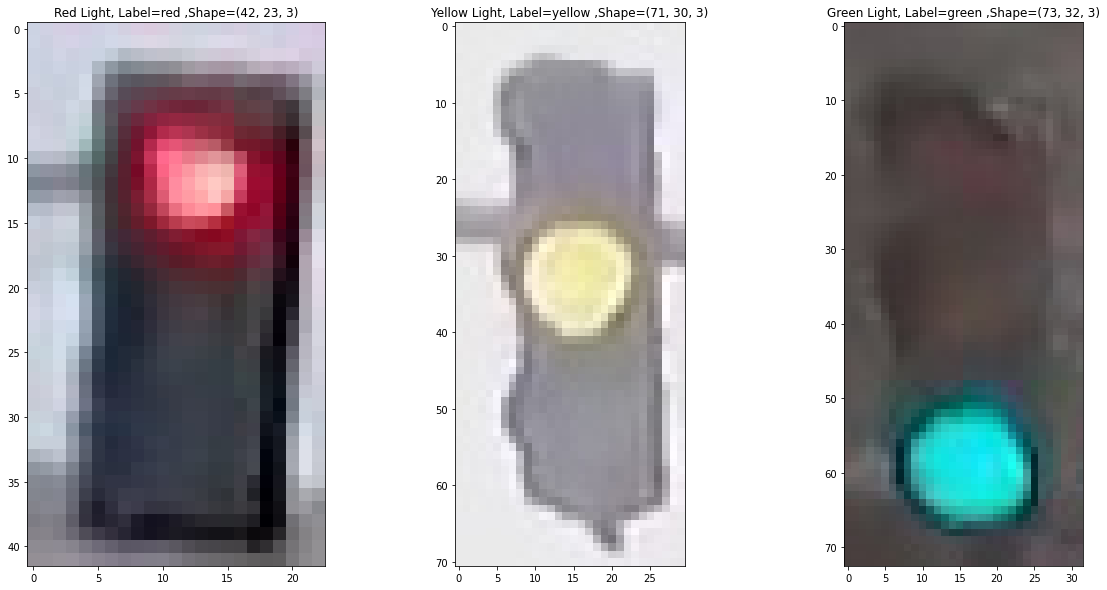

In [4]:
def genImageSubPlots(image_list, img_num = 0, showPlot = True, ):
    """
    This function displays the red, yellow and green traffic light images and returns 
    separate lists for each groups
    @param image_list - Input image list containing tuple pairs (image, image label)
    @param img_num - Index of the image to display in sub plot
    @param showPlot - Set to true if subplots need to be displayed
    @return Image_list_separate - Tuple pair of each red, yellow and green image lists
    """ 
    # Create new separate groups for red, yellow and green images for later analysis
    IMAGE_LIST_RED = []
    IMAGE_LIST_YELLOW = []
    IMAGE_LIST_GREEN = []
    for imgPair in image_list:
        if ((imgPair[1] == 'red') or (imgPair[1] == [1,0,0])):
            IMAGE_LIST_RED.append((imgPair[0],imgPair[1]))
        elif ((imgPair[1] == 'yellow') or (imgPair[1] == [0,1,0])):
            IMAGE_LIST_YELLOW.append((imgPair[0],imgPair[1]))
        elif ((imgPair[1] == 'green') or (imgPair[1] == [0,0,1])):
            IMAGE_LIST_GREEN.append((imgPair[0],imgPair[1]))
        else:
            raise ValueError("Invalid label!")

    Image_list_separate = (IMAGE_LIST_RED, IMAGE_LIST_YELLOW, IMAGE_LIST_GREEN)
    
    if showPlot == True:    
        f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20,10))
        ax1.set_title('Red Light,' + ' Label='+ str(IMAGE_LIST_RED[img_num][1]) + ' ,Shape=' + str(IMAGE_LIST_RED[img_num][0].shape))
        ax1.imshow(IMAGE_LIST_RED[img_num][0])
        ax2.set_title('Yellow Light,' + ' Label='+ str(IMAGE_LIST_YELLOW[img_num][1]) + ' ,Shape=' + str(IMAGE_LIST_YELLOW[img_num][0].shape))
        ax2.imshow(IMAGE_LIST_YELLOW[img_num][0])
        ax3.set_title('Green Light,' + ' Label='+ str(IMAGE_LIST_GREEN[img_num][1]) + ' ,Shape=' + str(IMAGE_LIST_GREEN[img_num][0].shape))
        ax3.imshow(IMAGE_LIST_GREEN[img_num][0])
    
    return Image_list_separate

_ = genImageSubPlots(IMAGE_LIST)

# 2. Pre-process the Data

After loading in each image, the next step is to standardize the input and output!

### Input

This means that every input image should be in the same format, of the same size, and so on. We'll be creating features by performing the same analysis on every picture, and for a classification task like this, it's important that **similar images create similar features**! 

### Output

We also need the output to be a label that is easy to read and easy to compare with other labels. It is good practice to convert categorical data like "red" and "green" to numerical data.

A very common classification output is a 1D list that is the length of the number of classes - three in the case of red, yellow, and green lights - with the values 0 or 1 indicating which class a certain image is. For example, since we have three classes (red, yellow, and green), we can make a list with the order: [red value, yellow value, green value]. In general, order does not matter, we choose the order [red value, yellow value, green value] in this case to reflect the position of each light in descending vertical order.

A red light should have the  label: [1, 0, 0]. Yellow should be: [0, 1, 0]. Green should be: [0, 0, 1]. These labels are called **one-hot encoded labels**.

*(Note: one-hot encoding will be especially important when working with [machine learning algorithms](https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/)).*

<img src="media/processing_steps.png" width="80%" height="80%">


---

### Standardize the input images

* Crop the image equally from all sides to remove the background noise
* Resize each image to the desired input size: 32x32px.

It's very common to have square input sizes that can be rotated (and remain the same size), and analyzed in smaller, square patches. It's also important to make all your images the same size so that they can be sent through the same pipeline of classification steps!

In [5]:
def standardize_input(image):
    """ 
    This function should take in an RGB image and return a new, standardized version
    Standardization includes -> Cropping + Resizing
    @param image - Input RGB image
    @return standard_im - Standardised image (32 x 32)
    """  
    
    #Crop the images equally from all sides
    px2crop = 7
    width = image.shape[0]
    height = image.shape[1]
    cropped = image[ px2crop:width-px2crop, px2crop:height-px2crop ]
    
    # Resize image and pre-process so that all "standard" images are the same size  
    standard_im = cv2.resize(cropped, (32, 32))
    
    return standard_im

## Standardize the output

With each loaded image, we also specify the expected output. For this, we use **one-hot encoding**.

* One-hot encode the labels. To do this, create an array of zeros representing each class of traffic light (red, yellow, green), and set the index of the expected class number to 1. 

Since we have three classes (red, yellow, and green), we have imposed an order of: [red value, yellow value, green value]. To one-hot encode, say, a yellow light, we would first initialize an array to [0, 0, 0] and change the middle value (the yellow value) to 1: [0, 1, 0].


In [6]:
def one_hot_encode(label):
    """
    Given a label - "red", "green", or "yellow" - return a one-hot encoded label

    Examples: 
    one_hot_encode("red") should return: [1, 0, 0]
    one_hot_encode("yellow") should return: [0, 1, 0]
    one_hot_encode("green") should return: [0, 0, 1]
    
    @param label - Input label ("red", "yellow", "green")
    @return one_hot_encoded - One hot encoded output label [r,y,g]
    """
    
    # Create a one-hot encoded label that works for all classes of traffic lights
    if label == "red":
        one_hot_encoded = [1,0,0]
    elif label == "yellow":
        one_hot_encoded = [0,1,0]
    elif label == "green":
        one_hot_encoded = [0,0,1]
    else:
        one_hot_encoded = [0,0,0]
    
    return one_hot_encoded

# test the function

label_test = one_hot_encode("green")
print(label_test)

[0, 0, 1]


### Testing as you Code

After programming a function like this, it's a good idea to test it, and see if it produces the expected output. **In general, it's good practice to test code in small, functional pieces, after you write it**. This way, you can make sure that your code is correct as you continue to build a classifier, and you can identify any errors early on so that they don't compound.

All test code can be found in the file `test_functions.py`.

One test function you'll find is: `test_one_hot(self, one_hot_function)` which takes in one argument, a one_hot_encode function, and tests its functionality. If our one_hot_label code does not work as expected, this test will print out an error message that will tell a bit about why our code failed. Once our code works, this should print out TEST PASSED.

In [7]:
# Importing the tests
import test_functions
tests = test_functions.Tests()

# Test for one_hot_encode function
tests.test_one_hot(one_hot_encode)


**<span style="color: green;">TEST PASSED</span>**

## Construct a `STANDARDIZED_LIST` of input images and output labels.

This function takes in a list of image-label pairs and outputs a **standardized** list of resized images and one-hot encoded labels.

This uses the functions we defined above to standardize the input and output, so those functions must be complete for this standardization to work!


In [8]:
def standardize(image_list):
    
    # Empty image data array
    standard_list = []

    # Iterate through all the image-label pairs
    for item in image_list:
        image = item[0]
        label = item[1]

        # Standardize the image
        standardized_im = standardize_input(image)

        # One-hot encode the label
        one_hot_label = one_hot_encode(label)    

        # Append the image, and it's one hot encoded label to the full, processed list of image data 
        standard_list.append((standardized_im, one_hot_label))
        
    return standard_list

# Standardize all training images
STANDARDIZED_LIST = standardize(IMAGE_LIST)

## Visualize the standardized data

Display a standardized image from STANDARDIZED_LIST and compare it with a non-standardized image from IMAGE_LIST. Note that their sizes and appearance are different!

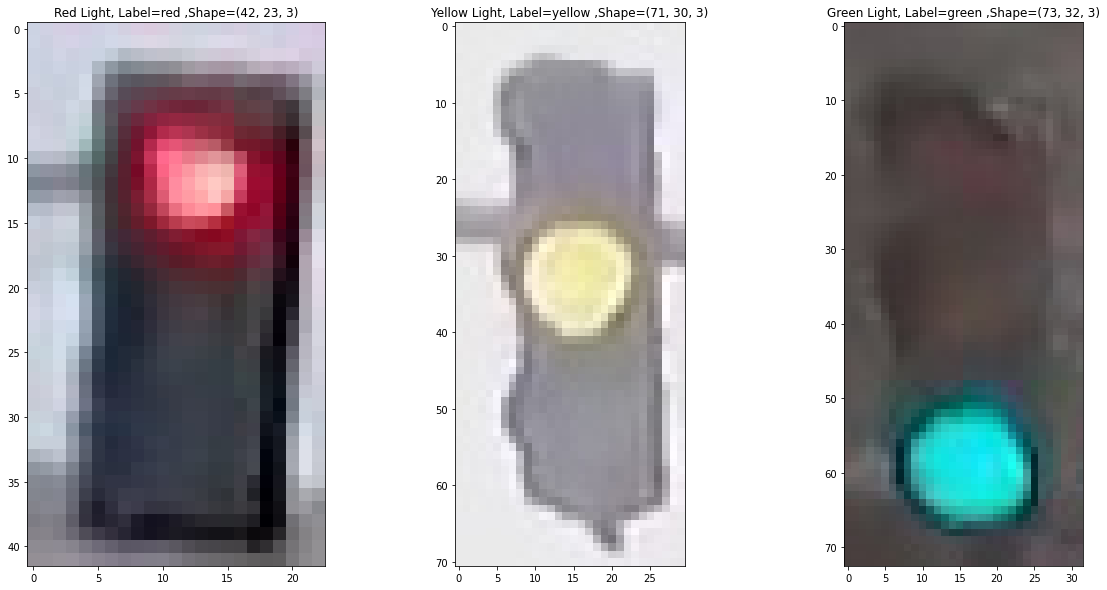

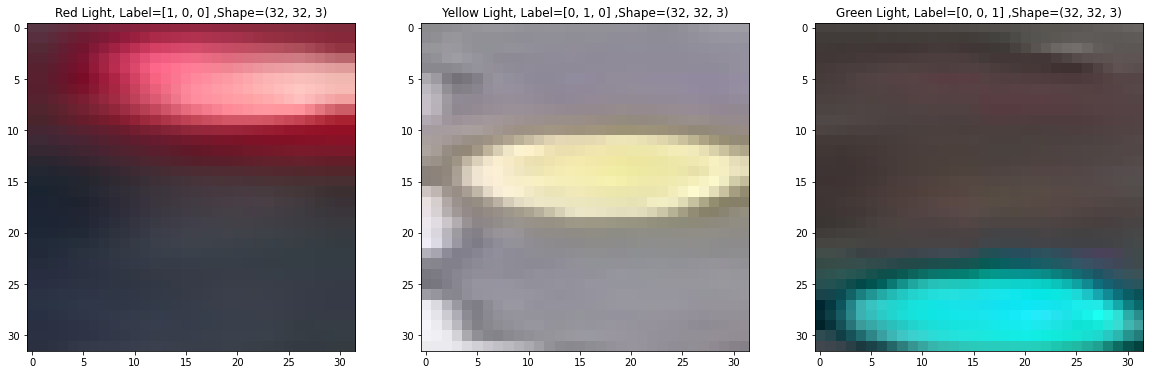

In [9]:
# Display a standardized image and its label
RedImageListRaw, YellowImageListRaw, GreenImageListRaw = genImageSubPlots(IMAGE_LIST)
RedImageList, YellowImageList, GreenImageList = genImageSubPlots(STANDARDIZED_LIST) 

# 3. Feature Extraction

We will use some basic computer vision techniques to extract features from the images which will help us classify the three types of traffic light. 

The underlying concept involves identifying the precise color (be it red, yellow or green) and its location within the traffic light image through two distinct methods:

- First, the "create_color_mask" function is used to extract the desired color from the image while simultaneously masking any extraneous elements. This operation is performed to obtain a pixel count within the specified color range.

- Subsequently, the resultant masked image is fed into the "vCh1dVector" function, which generates a one-dimensional array portraying the spatial distribution of luminance (i.e., V channel) across the vertical axis. This process allows for the precise determination of the traffic light's location in the image. Specifically, red lights are expected to appear in the top section, yellow in the middle, and green in the lower portion.

The final classification involves employing both the above techniques. Firstly, the maximum number of pixels within the red, yellow, and green color ranges is determined to classify the traffic light. Secondly, to ensure that the red light is not erroneously classified as green, the second function is utilized to ascertain the precise location of the traffic light in the image. As previously mentioned, the anticipated position of the red light is at the top of the image, while yellow appears in the middle, and green in the lowest portion of the image.

## RGB to HSV conversion

Below, a test image is converted from RGB to HSV colorspace and each component is displayed in an image.

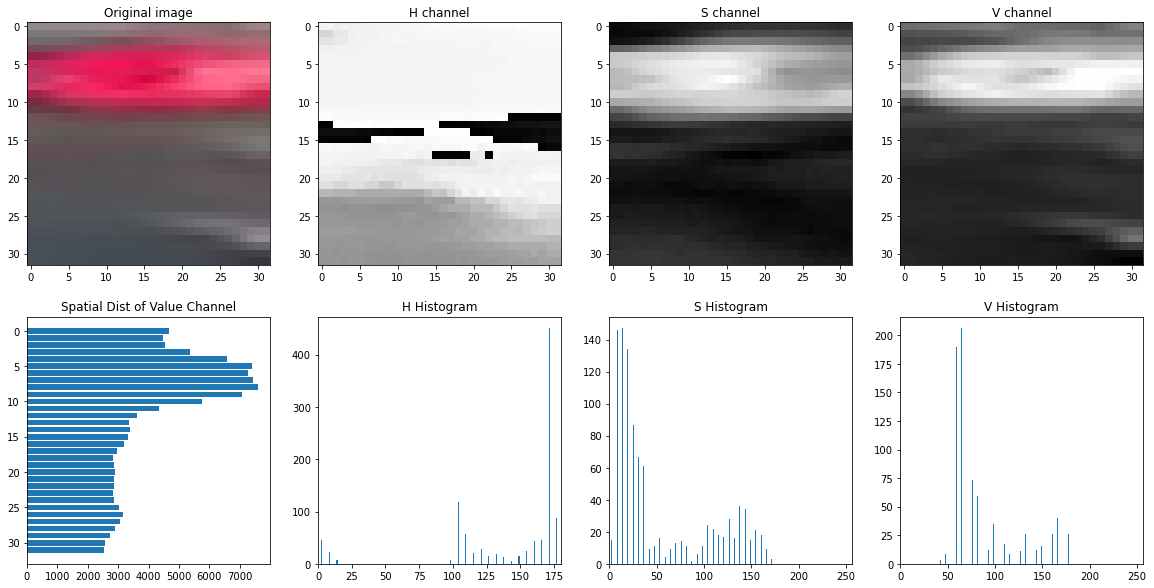

In [10]:
# Visualize the individual color channels
def hsvHistVisualizer(test_im, showPlots = True):
    """ 
    This function plots the HSV histogram of the rgb image
    It also plots the spatial distribution of Value channel
    
    @param  test_im - Input RGB image
    @param  showPlots - True if plot is displayed
    (Optional) @return h_hist, s_hist, v_hist, v_sum - Total number of pixels in h,s,v channels. v_sum is the column wise sum of value channel
    """

    # Convert to HSV
    hsv = cv2.cvtColor(test_im, cv2.COLOR_RGB2HSV)

    # HSV channels
    h = hsv[:,:,0]
    s = hsv[:,:,1]
    v = hsv[:,:,2]
    
    # Sum the V component over all rows (axis = 1)
    v_sum = np.sum(v[:,:], axis=1)
    
    # Create color channel histograms
    h_hist = np.histogram(hsv[:, :, 0], bins=32, range=(0, 180))
    s_hist = np.histogram(hsv[:, :, 1], bins=32, range=(0, 256))
    v_hist = np.histogram(hsv[:, :, 2], bins=32, range=(0, 256))
    
    # Generating bin centers
    bin_edges = h_hist[1]
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2

    if showPlots:
        
        # Plot the original image and the three channels
        f, ((ax1, ax2, ax3, ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2, 4, figsize=(20,10))
        ax1.set_title('Original image')
        ax1.imshow(test_im)
        
        ax2.set_title('H channel')
        ax2.imshow(h, cmap='gray')
        
        ax3.set_title('S channel')
        ax3.imshow(s, cmap='gray')
        
        ax4.set_title('V channel')
        ax4.imshow(v, cmap='gray') 
        
        # Plot figures with all three histograms
        ax5.set_title('Spatial Dist of Value Channel')
        ax5.barh(range(32),v_sum)
        ax5.invert_yaxis()
        
        ax6.set_title('H Histogram')
        ax6.bar(bin_centers, h_hist[0])
        ax6.set_xlim(0, 180)
        
        ax7.set_title('S Histogram') 
        ax7.bar(bin_centers, s_hist[0])
        ax7.set_xlim(0, 256)
        
        ax8.set_title('V Histogram') 
        ax8.bar(bin_centers, v_hist[0])
        ax8.set_xlim(0, 256)
    #return h_hist, s_hist, v_hist, v_sum

hsvHistVisualizer(RedImageList[40][0])

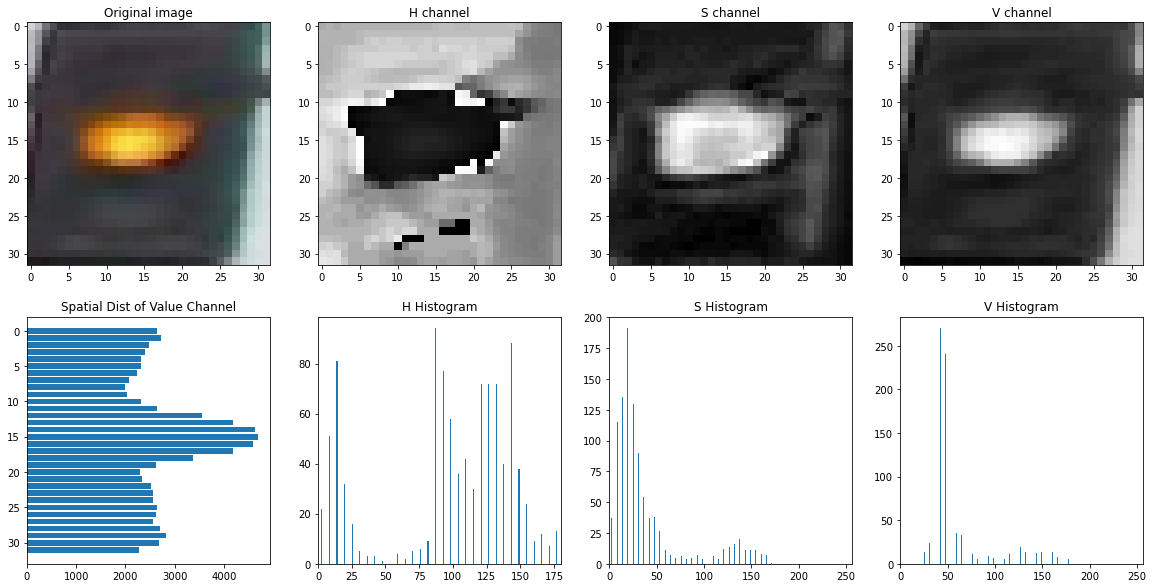

In [11]:
hsvHistVisualizer(YellowImageList[3][0])

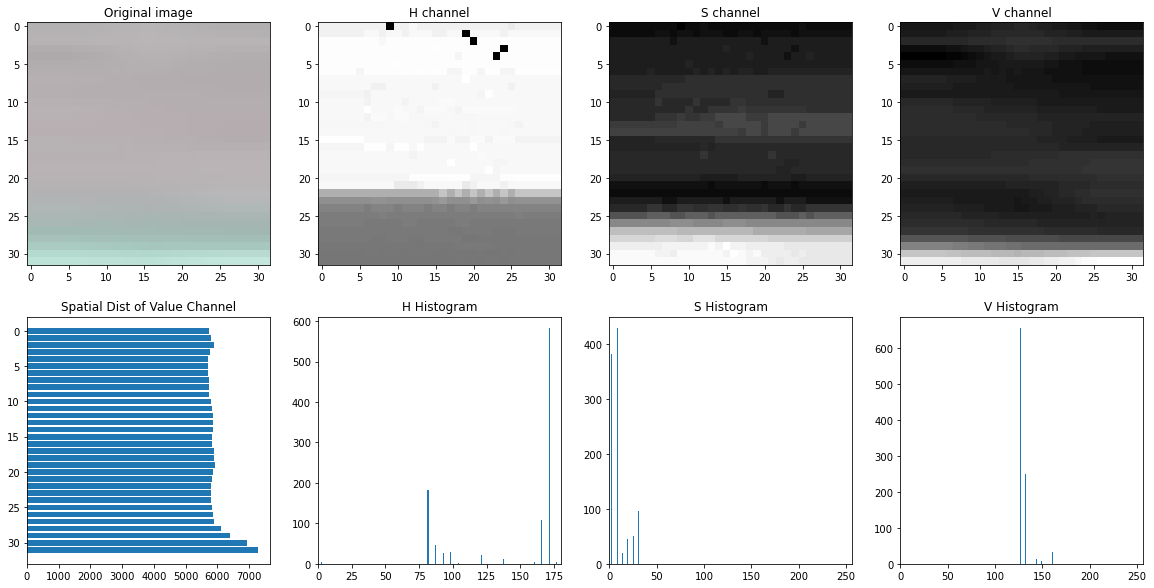

In [12]:
hsvHistVisualizer(GreenImageList[-1][0])

Based on above image analysis, HSV thresholds are defined for each color (Red, Yellow and Green) which will be later used for masking. Also, take note of the spatial distribution of the Value channel, it has a peak at the position where there is a traffic light. This metric will be used in our function *vCh1dVector*

In [13]:
lowerRed = (160, 30, 150)
upperRed = (179, 255, 255)

lowerYellow = (15, 20, 150)
upperYellow = (30, 255, 255)

lowerGreen = (80, 10, 120)
upperGreen = (100, 255, 255)

In [14]:
def vCh1dVector(rgb_image, showPlot= False):
    """ 
    Output a 1d vector containing heightwise spatial distribution of Value channel of an image 
    
    @param rgb_image - Input RGB image
    @param showPlot - True if plot is displayed
    @return v_sum - 1d vector containing height wise distribution of Value channel values
    """
    
    # Convert to HSV
    hsv = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)
    v = hsv[:,:,2]
    
    # Sum the V component over all rows (axis = 1)
    v_sum = np.sum(v[:,:], axis=1) 
    
    if showPlot:
        # Plot figures with spatial distribution
        f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
        ax1.set_title('Original image')
        ax1.imshow(rgb_image)

        ax2.set_title('Heightwise Spatial Dist of Value Channel')
        ax2.barh(range(rgb_image.shape[0]),v_sum)
        ax2.invert_yaxis()   
  
    return v_sum


In [15]:
def create_color_mask(rgb_image, lowerThres, upperThres, showPlot = False):
    """ 
    This function gives a masked output of the input rgb image based on the color threshold in hsv
    
    @param rgb_image - Input RGB image
    @param lowerThres - Lower bound of the required HSV color value (h,s,v)
    @param upperThres - Upper bound of the required HSV color value (h,s,v)
    @param showPlot - True if plot is displayed
    @return out_rgb_image - RGB image with mask
    @return mask - Output masked image
    """
    
    # Convert to HSV
    hsv = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)

    # Create a b&w mask where the required area is white (255) and remaining area is black
    mask = cv2.inRange(hsv, lowerThres, upperThres)
    
    out_rgb_image = np.copy(rgb_image)
    
    #Mask the unwanted area from image
    out_rgb_image[mask != 255] = [0,0,0]
    
    if showPlot:
        f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (10,5))
        ax1.set_title('Original image')
        ax1.imshow(rgb_image)

        ax2.set_title('Mask')
        ax2.imshow(mask, cmap='gray')
        
        ax3.set_title('Masked image')
        ax3.imshow(out_rgb_image)
    
    return out_rgb_image, mask

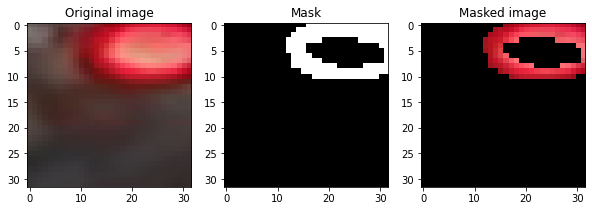

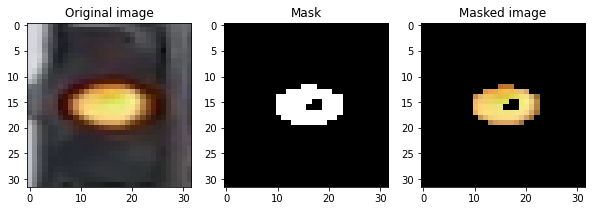

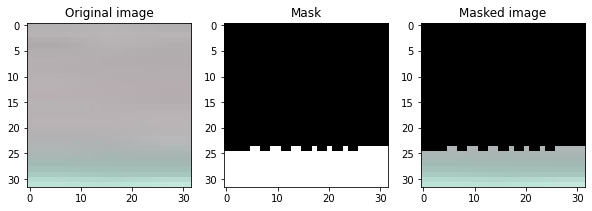

In [16]:
# Visualize the mask function output
r,rm = create_color_mask(RedImageList[-1][0],lowerRed, upperRed, showPlot=True)
y,ym = create_color_mask(YellowImageList[-1][0],lowerYellow, upperYellow, showPlot=True)
g,gm = create_color_mask(GreenImageList[-1][0],lowerGreen, upperGreen, showPlot=True)

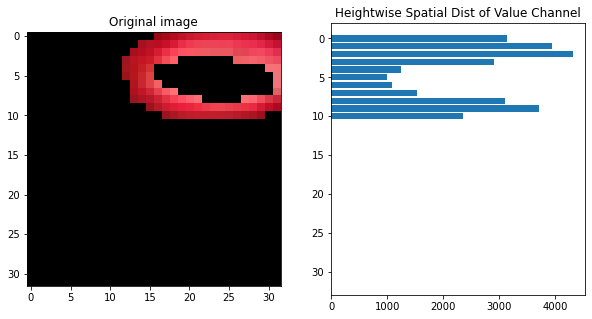

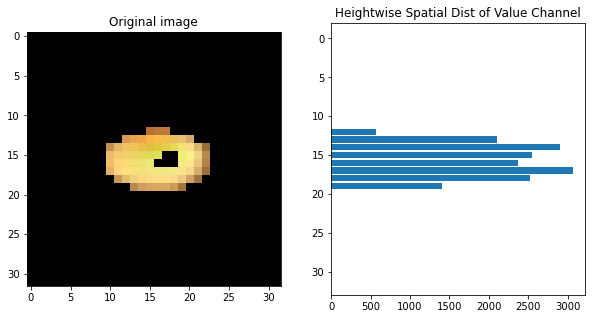

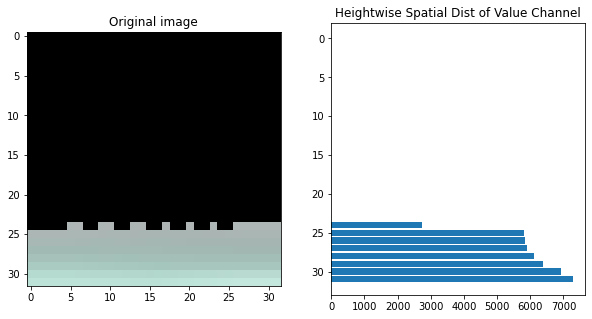

In [17]:
# Visualize the spatial distribution of colors
_ = vCh1dVector(r, True)
_ = vCh1dVector(y, True)
_ = vCh1dVector(g, True)

# 4. Classification and Visualizing Error

Using all the features that we built before, now we can create a classifier which, given an input standardised image, can output the `one hot encoded label` and classify the image as RED, YELLOW or GREEN traffic light.

---
### Build a complete classifier 

In [18]:
def estimate_label(rgb_image, showPlot = False):
    """ 
    This function classifies the active traffic light color from the input rgb image
    
    @param rgb_image - Input RGB image
    @param showPlot - True if plot is displayed
    @return predicted_label - Predicted label of the image. (1,0,0)-> red ; (0,1,0) -> yellow; (0,0,1) -> green
    """
    
    red_im, red_mask = create_color_mask(rgb_image,lowerRed, upperRed, showPlot)
    yellow_im, yellow_mask = create_color_mask(rgb_image,lowerYellow, upperYellow, showPlot)
    green_im, green_mask = create_color_mask(rgb_image,lowerGreen, upperGreen, showPlot)
    
    # Count the number of white pixels in each color mask
    red_pixels = cv2.countNonZero(red_mask)
    yellow_pixels = cv2.countNonZero(yellow_mask)
    green_pixels = cv2.countNonZero(green_mask)
    
    # Index the color which has the maximum number of white pixels in the masked image
    max_pixel_arg = np.argmax([red_pixels, yellow_pixels, green_pixels])
    max_pixel_val = np.max([red_pixels, yellow_pixels, green_pixels])
    
    # Calculate 1D vector of spatial distribution of luminance in the masked image
    im_vector = vCh1dVector(red_im+yellow_im+green_im,showPlot)
    
    # Divide image in three parts and sum the count of pixels in top, middle and down position of image
    top_index = np.int8(np.ceil(len(im_vector)/3) + 1)
    middle_index_high = 2*top_index - 2
    
    top_pixels = np.sum(im_vector[:top_index])
    middle_pixels = np.sum(im_vector[top_index:middle_index_high])
    down_pixels = np.sum(im_vector[middle_index_high:])
    
    # Index the position which has the maximum number of pixels in the image
    max_pixel_pos = np.argmax([top_pixels, middle_pixels, down_pixels])
    max_pixel_pos_val = np.max([top_pixels, middle_pixels, down_pixels])    
    
    # If there are no pixels in the mask then set the predicted label to [0,0,0]
    if max_pixel_val == 0 or max_pixel_pos_val == 0:
        predicted_label = [0,0,0]
    else:
        # Classify the image based on color and position
        if max_pixel_arg == 0:
            predicted_label = [1,0,0]
        elif max_pixel_arg == 1 and max_pixel_pos == 1:
            predicted_label = [0,1,0]
        elif max_pixel_arg == 2 and max_pixel_pos == 2:
            predicted_label = [0,0,1]
        else:
            predicted_label = [0,0,0]
    
    return predicted_label

## Testing the classifier

Here is where we test your classification algorithm using our test set of data that we set aside at the beginning of the notebook!

A "good" classifier in this case should meet the following criteria
1. Get above 90% classification accuracy.
2. Never classify a red light as a green light. 

### Test dataset

Below, we load in the test dataset, standardize it using the `standardize` function we defined above, and then **shuffle** it; this ensures that order will not play a role in testing accuracy.


In [19]:
# Using the load_dataset function in helpers.py
# Load test data
TEST_IMAGE_LIST = helpers.load_dataset(IMAGE_DIR_TEST)

# Standardize the test data
STANDARDIZED_TEST_LIST = standardize(TEST_IMAGE_LIST)

# Shuffle the standardized test data
random.shuffle(STANDARDIZED_TEST_LIST)

## Determine the Accuracy

Compare the output of the classification algorithm with the true labels and determine the accuracy.

This code stores all the misclassified images, their predicted labels, and their true labels, in a list called `MISCLASSIFIED`.

In [20]:
def get_misclassified_images(test_images):
    """
    Constructs a list of misclassified images given a list of test images and their labels
    This will throw an AssertionError if labels are not standardized (one-hot encoded)
    
    @param test_image - Input RGB image
    @return misclassified_images_labels - One hot encoded labels of misclassified images
    """
    
    # Track misclassified images by placing them into a list
    misclassified_images_labels = []

    # Iterate through all the test images
    # Classify each image and compare to the true label
    i=0
    for image in test_images:

        # Get true data
        im = image[0]
        true_label = image[1]
        assert(len(true_label) == 3), "The true_label is not the expected length (3)."

        # Get predicted label from your classifier
        predicted_label = estimate_label(im)
        assert(len(predicted_label) == 3), "The predicted_label is not the expected length (3)."

        # Compare true and predicted labels 
        if(predicted_label != true_label):
            # If these labels are not equal, the image has been misclassified
            misclassified_images_labels.append((im, predicted_label, true_label))
            
    # Return the list of misclassified [image, predicted_label, true_label] values
    return misclassified_images_labels


# Find all misclassified images in a given test set
MISCLASSIFIED = get_misclassified_images(STANDARDIZED_TEST_LIST)

# Accuracy calculations
total = len(STANDARDIZED_TEST_LIST)
num_correct = total - len(MISCLASSIFIED)
accuracy = num_correct/total

print('Accuracy: ' + str(accuracy))
print("Number of misclassified images = " + str(len(MISCLASSIFIED)) +' out of '+ str(total))


Accuracy: 0.9764309764309764
Number of misclassified images = 7 out of 297


## Test if you classify any red lights as green

Classifying red lights as green would cause a car to drive through a red traffic light, so this red-as-green error is very dangerous in the real world. 

The code below test to see if we've misclassified any red lights as green in the test set. **This test assumes that `MISCLASSIFIED` is a list of tuples with the order: [misclassified_image, predicted_label, true_label].**

In [21]:
# Importing the tests
import test_functions
tests = test_functions.Tests()

if(len(MISCLASSIFIED) > 0):
    # Test code for one_hot_encode function
    tests.test_red_as_green(MISCLASSIFIED)
else:
    print("MISCLASSIFIED may not have been populated with images.")


**<span style="color: green;">TEST PASSED</span>**

---

### Visualize the misclassified images

Visualize some of the images we classified wrong (in the `MISCLASSIFIED` list)

Predicted Label is: [0, 0, 0]


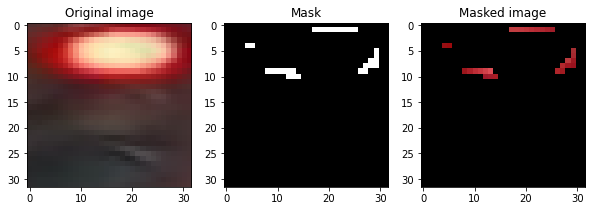

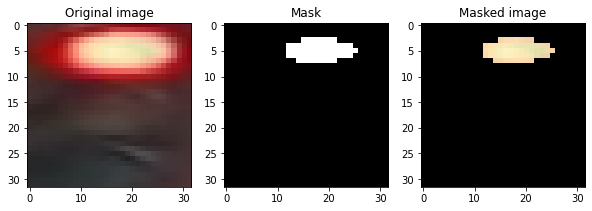

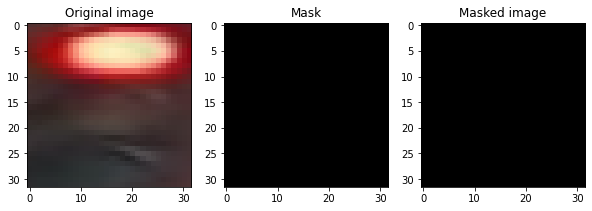

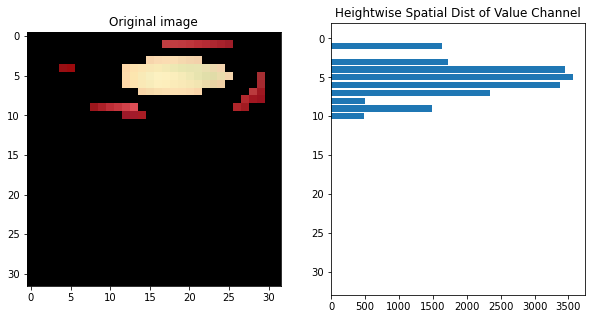

In [22]:
# Visualize misclassified example(s)
num = 1
test_mis_im = MISCLASSIFIED[num][0]
test_mis_lbl = MISCLASSIFIED[num][1]

# Print out its predicted label -
print("Predicted Label is:", test_mis_lbl)
# Display an image in the `MISCLASSIFIED` list
lab = estimate_label(test_mis_im, True)

---

### Weakness of current algorithm:

1. The current classification algorithm does not work well if the traffic light in the image is tilted by a significant angle.
2. It will also not work if the traffic light is offset too much within the image. The position feature will not be able to detect the position of light accurately. 
3. This algorithm will not give accurate results if there are multiple traffic lights in the image.
4. The algorithm uses fixed values of HSV thresholds for color masking. This can be further improved by using adaptive thresholds or using deep learning techniques.